## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'coco-indoor' 
TRANSFORM = 'wavelet-vertical'
CHANNEL = 'green'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
green_vertical_wavelet_indoor_coco.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/coco/indoor/wavelet/vertical/green'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 1604,
 3: 6416,
 4: 25664,
 5: 102656,
 6: 410624,
 7: 1642496,
 8: 6569984,
 9: 26279936}

Running 12760 CDFs


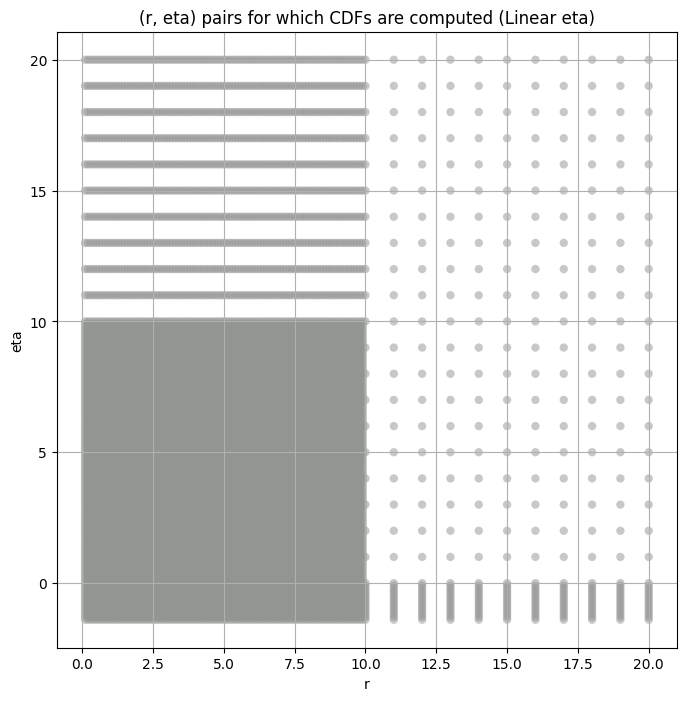

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df['total_samples'] = master_df['total_samples'].astype(int)
    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      1.944126e+07  1.727396e+07  2.176802e+07   1.198365    0.473946   
3      4.688396e+06  4.386526e+06  4.998034e+06   2.127208    1.684596   
4      9.987222e+05  9.389650e+05  1.060140e+06   3.486293    2.938743   
5      1.964666e+05  1.828806e+05  2.107052e+05   5.660023    4.755314   
6      3.547586e+04  3.247593e+04  3.864024e+04   9.517805    7.861723   
7      6.216240e+03  5.591804e+03  6.895085e+03  14.437410   11.702306   
8      1.162606e+03  1.020683e+03  1.318852e+03  22.518257   17.539236   
9      2.479359e+02  2.136317e+02  2.857319e+02  30.058044   22.701000   

       kurt_upper  total_samples  
layer                             
2        2.049889           1604  
3        2.595376           6416  
4        4.103294          25664  
5        6.740086         102656  
6       11.440639         410624  
7       18.183810        1642496  
8       28.702457        6569984  
9       40.466720       26279936

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                
2      1.944126e+07   1.944126e+07    1.479134e+07    1.255409e+07   
3      4.688396e+06   4.688396e+06    4.166414e+06    3.844578e+06   
4      9.987222e+05   9.987222e+05    9.508929e+05    9.167421e+05   
5      1.964666e+05   1.964666e+05    1.923357e+05    1.892392e+05   
6      3.547586e+04   3.547586e+04    3.440807e+04    3.361610e+04   
7      6.216240e+03   6.216240e+03    5.972694e+03    5.798412e+03   
8      1.162606e+03   1.162606e+03    1.098849e+03    1.054474e+03   
9      2.479359e+02   2.479359e+02    2.313081e+02    2.199466e+02   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2        1.085835e+07     9.460503e+06     7.332956e+06     5.719800e+06   
3        3.593237e+06     3.379653e+06     3.020750e+06     2.726390e+06   
4        8.879526e+05     8.625817e+05     8.183791e+05     7.809252e+05   
5        1.865103e+05     1.840341e+05     1.795803e+05     1.756154e+05   
6        3.294604e+04     3.234228e+04     3.129240e+04     3.037104e+04   
7        5.648260e+03     5.514865e+03     5.282575e+03     5.082897e+03   
8        1.017826e+03     9.860475e+02     9.321406e+02     8.868859e+02   
9        2.106629e+02     2.026958e+02     1.893959e+02     1.784664e+02   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2         4.451518e+06     3.432880e+06     2.599452e+06     9.882732e+05  
3         2.480869e+06     2.267507e+06     2.086966e+06     1.657461e+06  
4         7.480444e+05     7.187579e+05     6.921392e+05     6.239646e+05  
5         1.720414e+05     1.687444e+05     1.656607e+05     1.573165e+05  
6         2.955034e+04     2.880022e+04     2.810736e+04     2.628944e+04  
7         4.906068e+03     4.746271e+03     4.600404e+03     4.226065e+03  
8         8.475612e+02     8.126928e+02     7.813068e+02     7.022974e+02  
9         1.691366e+02     1.609883e+02     1.537600e+02     1.360106e+02

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.016244003604470925 19441260.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.03244247166639273 14791340.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.048812426902151734 12554089.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.06236238796830587 10858350.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.07484960277282234 9460503.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.10217163919680582 7332956.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.12765312772090995 5719800.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.15037114669195473 4451518.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.17442291006088873 3432879.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.1999478554728581 2599451.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.2829229294939725 988273.25
Number of samples: 1604, Without approximation : 1604


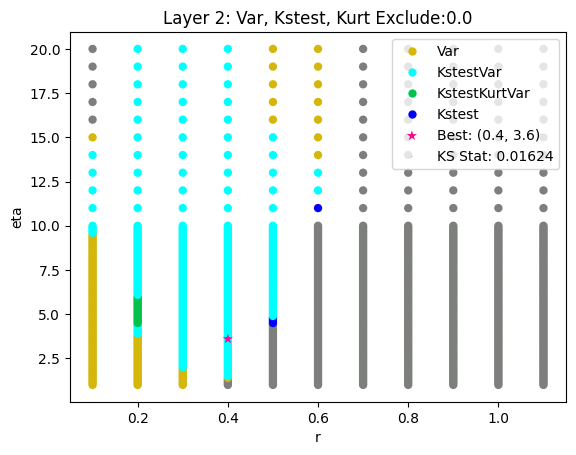

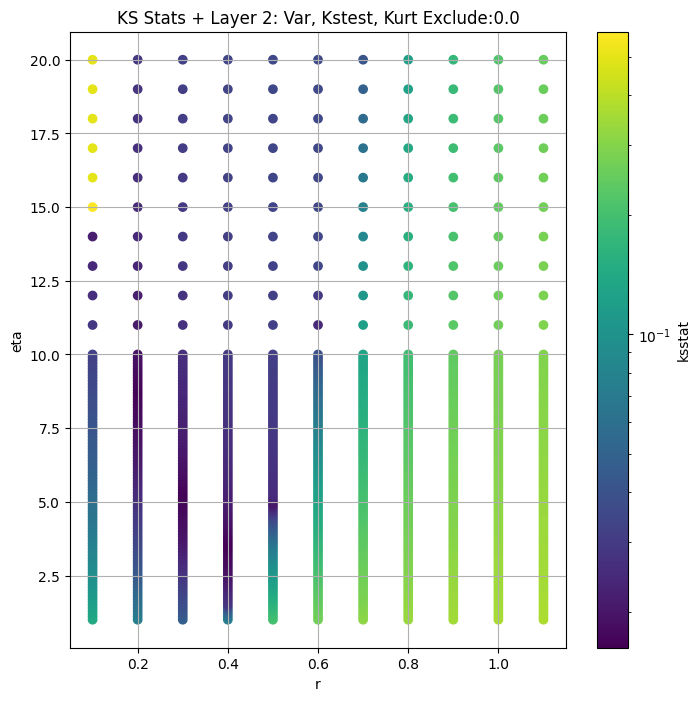

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.009067231540683535 4688396.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.013286077354001183 4166414.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.016259664089855318 3844578.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.020262935070791507 3593237.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.024004786396329157 3379652.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.03180512265250229 3020749.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.03973821062313657 2726390.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.0478908905269662 2480868.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.05592075123209968 2267506.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.06282939428890177 2086966.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.07974694142042689 1657461.2
Number of samples: 6416, Without approximation : 6416


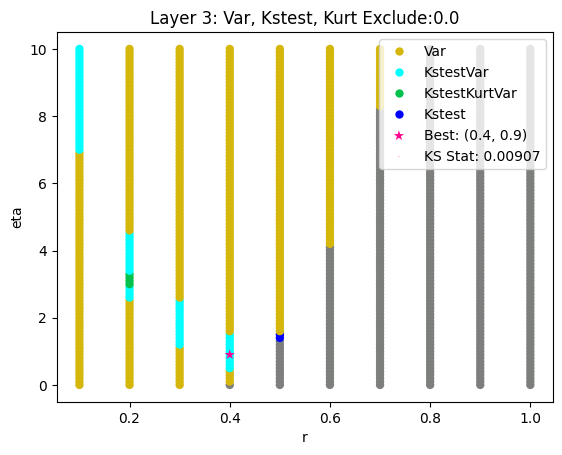

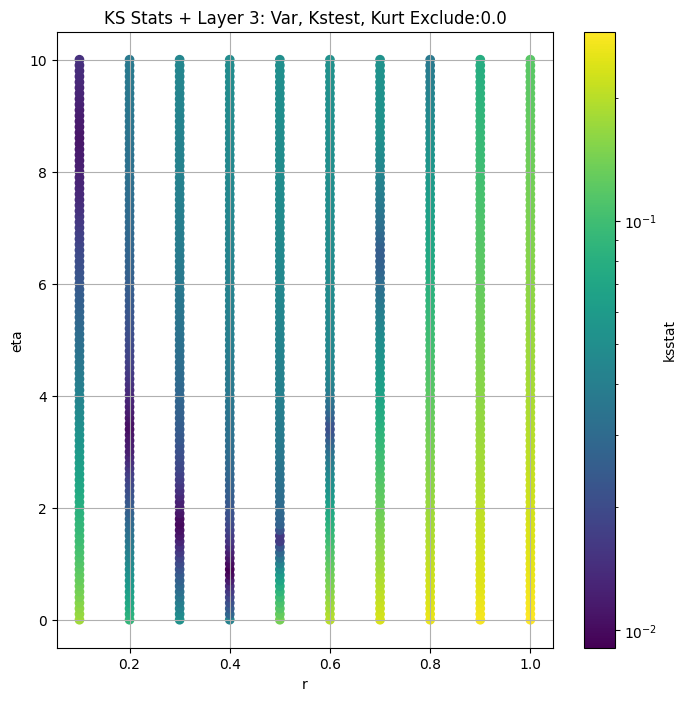

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.009866952933585638 998722.25


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.011333719704264555 950892.94


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.011820523019008378 916742.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.013437114639228837 887952.56


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.014334974569860173 862581.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.016439300146371516 818379.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.01878096973843528 780925.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.020643434787324486 748044.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.02189131048363613 718757.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.023859851679427953 692139.25


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.029428447118363454 623964.56
Number of samples: 25664, Without approximation : 25664


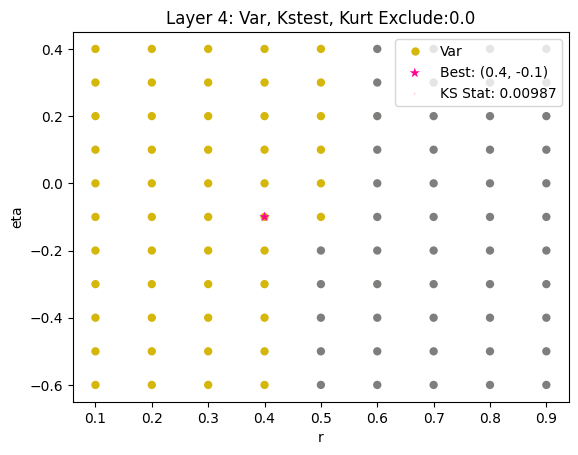

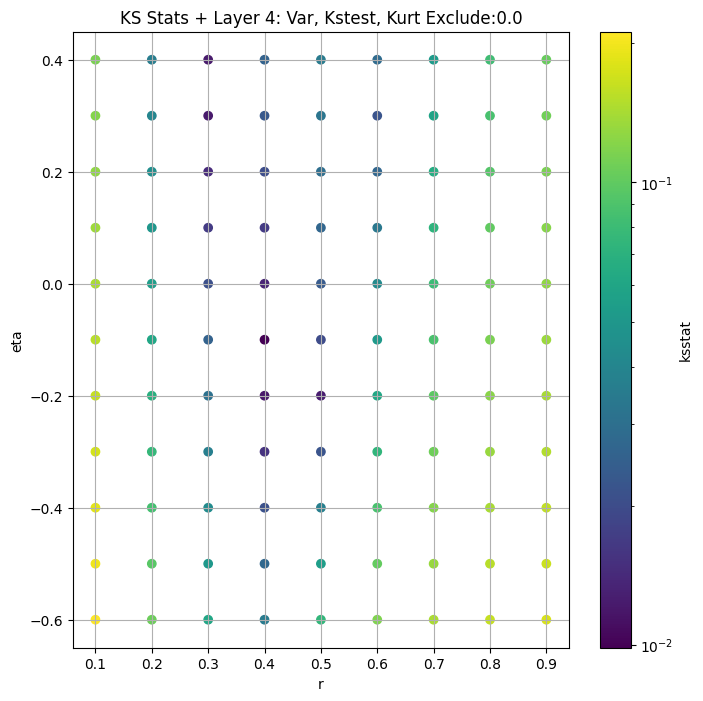

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.011154244457107665 196466.64


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.010338182165380183 192335.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.009675120249043934 189239.17


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.010506850475433427 186510.28


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.011268464657208321 184034.12


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.01265528295891094 179580.31


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.01390861793061171 175615.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.015053928941627381 172041.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.014704042329586942 168744.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.013694481676842674 165660.69


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.01588190945172341 157316.48
Number of samples: 100000, Without approximation : 102656


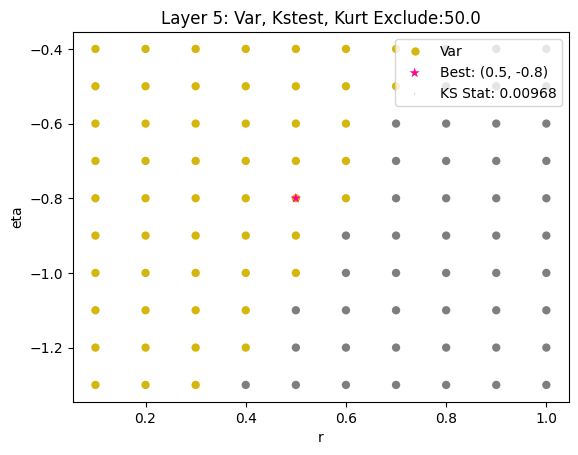

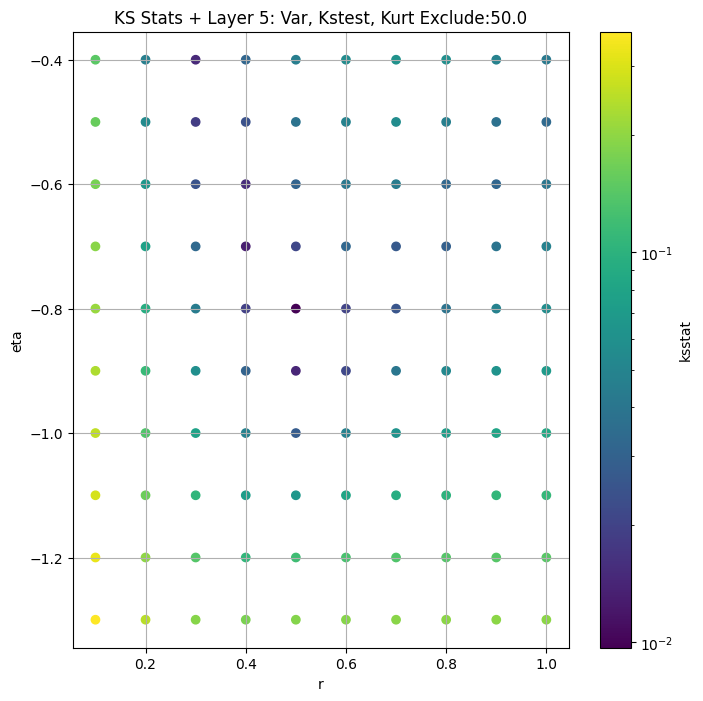

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.012029758477942243 35475.86


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.013612526547222753 34408.07


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.01482740855874172 33616.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.014544970567851423 32946.04


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.013589282716181261 32342.275


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.011984142080454452 31292.402


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.01083269903168882 30371.037


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.01141111602272217 29550.34


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.01254426810039113 28800.219


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.013681851842354445 28107.36


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.014523609447911368 26289.436
Number of samples: 100000, Without approximation : 410624


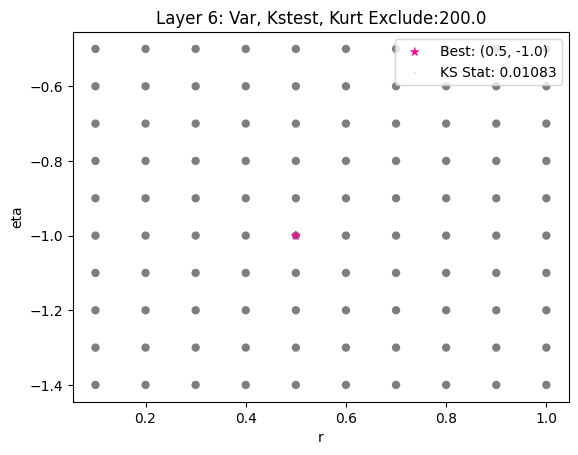

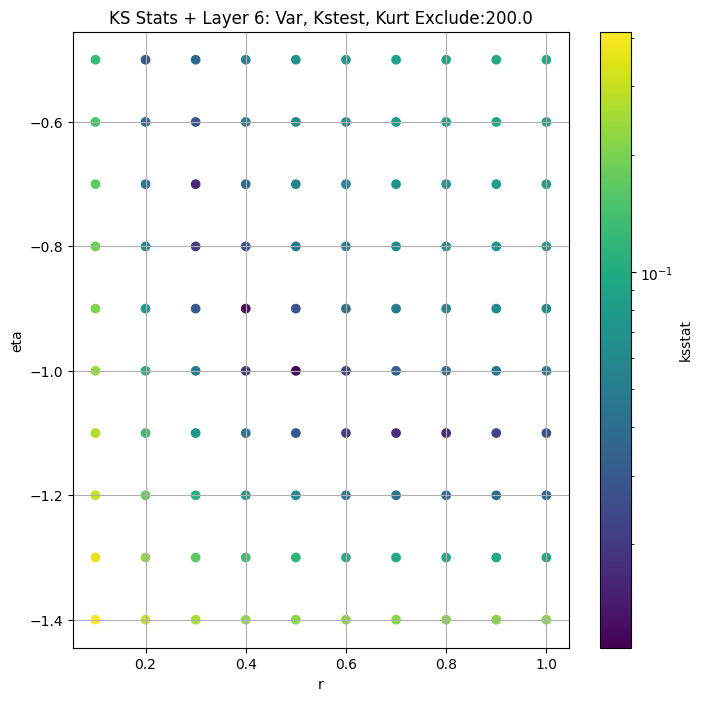

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.024152439800642522 6216.24


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.023055764314720062 5972.6943


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.021505875564961585 5798.4116


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.02065963444920682 5648.26


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.020394273380474892 5514.8647


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.019911294648777167 5282.575


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.01947311550558084 5082.8975


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.01906563655490462 4906.068


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.019916292907286803 4746.271


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.02085206565226061 4600.404


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.021091491024799458 4226.0654
Number of samples: 100000, Without approximation : 1642496


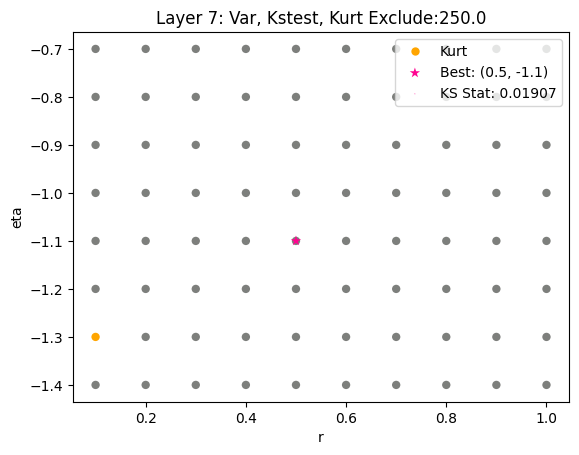

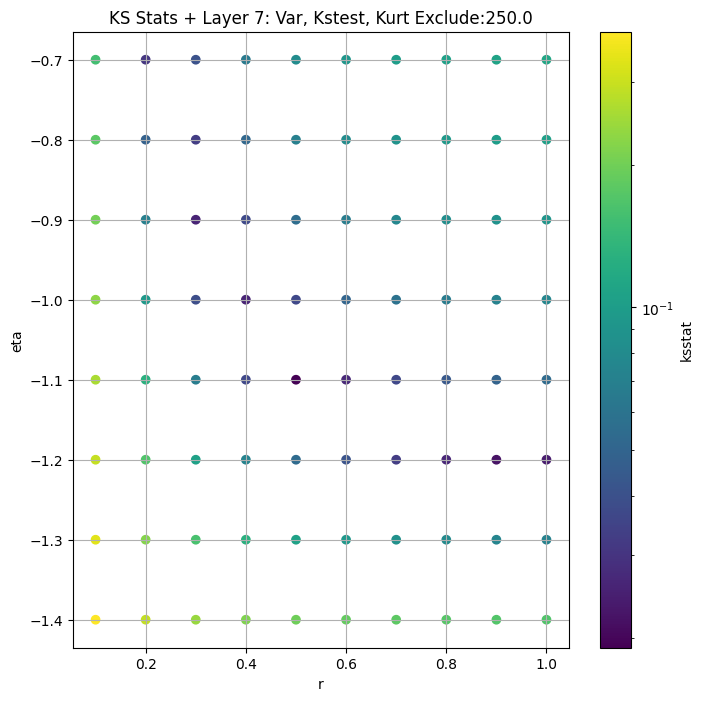

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.009713856540274124 1162.6064


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.009724574713974116 1098.849


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.007222715583886735 1054.474


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.006668215983735126 1017.8265


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.00761307949486123 986.0475


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.009370141855157166 932.14056


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.01110145351744174 886.8859


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.010084755522637101 847.5612


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.010525539124617622 812.6928


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.009513152860507947 781.3068


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.0115203381786389 702.2974
Number of samples: 100000, Without approximation : 6569984


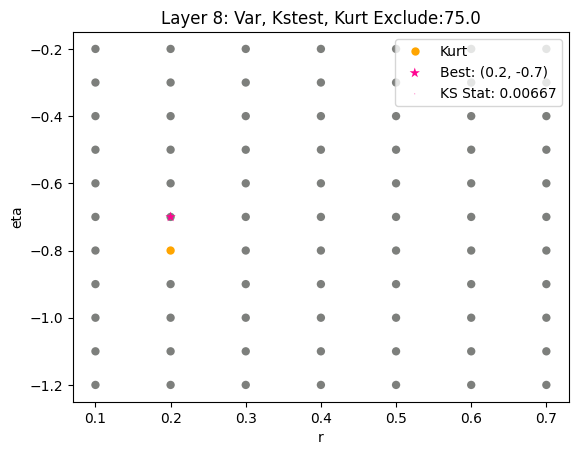

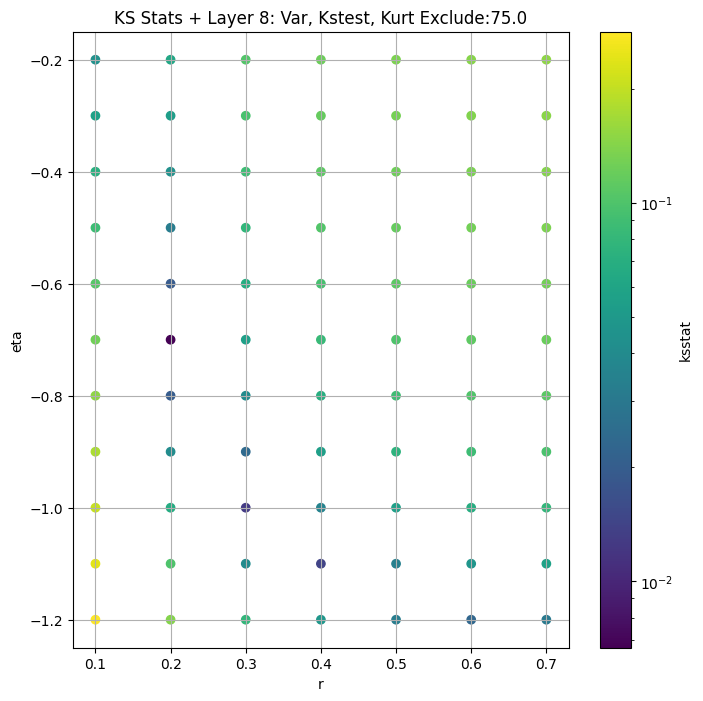

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.014506938957223992 247.93588


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.012164207904282298 231.30809


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.01321053484719309 219.94661


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.01553662090304167 210.66287


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.015192943409744086 202.69576


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.015524601544176328 189.3959


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.016574244873045485 178.46643


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.01371736992365935 169.13658


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.014256201473066554 160.98827


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.014895406000214106 153.75998


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.01708047822825598 136.01062
Number of samples: 100000, Without approximation : 26279936


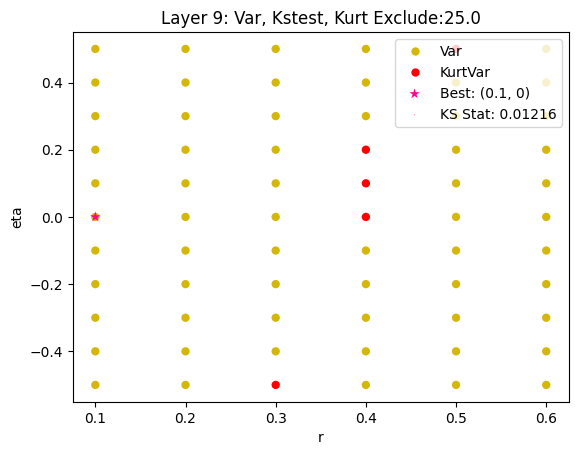

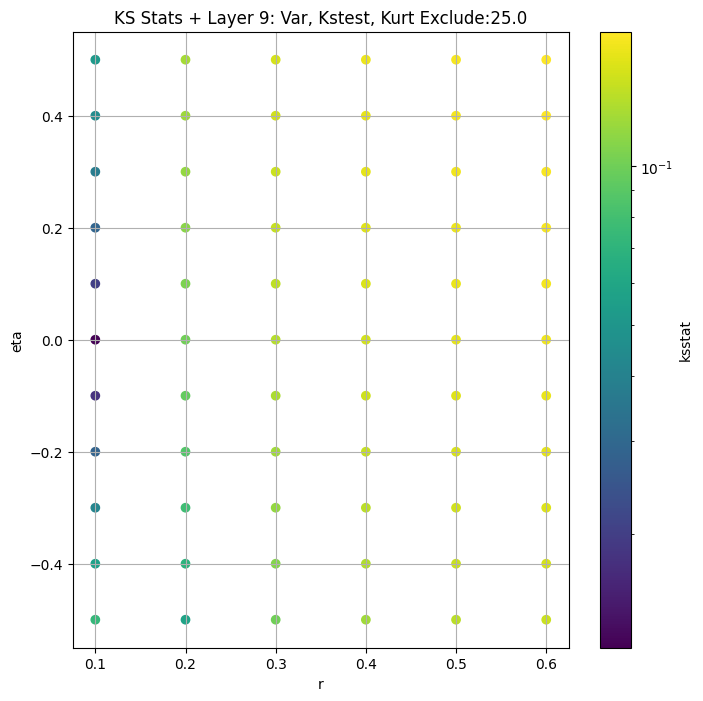

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      1.944126e+07  1.727396e+07  2.176802e+07   1.198365    0.473946   
3      4.688396e+06  4.386526e+06  4.998034e+06   2.127208    1.684596   
4      9.987222e+05  9.389650e+05  1.060140e+06   3.486293    2.938743   
5      1.964666e+05  1.828806e+05  2.107052e+05   5.660023    4.755314   
6      3.547586e+04  3.247593e+04  3.864024e+04   9.517805    7.861723   
7      6.216240e+03  5.591804e+03  6.895085e+03  14.437410   11.702306   
8      1.162606e+03  1.020683e+03  1.318852e+03  22.518257   17.539236   
9      2.479359e+02  2.136317e+02  2.857319e+02  30.058044   22.701000   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        2.049889           1604             0.016244        0.4          3.6   
3        2.595376           6416             0.009067        0.4          0.9   
4        4.103294          25664             0.009867        0.4         -0.1   
5        6.740086         102656             0.009675        0.5         -0.8   
6       11.440639         410624             0.010833        0.5         -1.0   
7       18.183810        1642496             0.019066        0.5         -1.1   
8       28.702457        6569984             0.006668        0.2         -0.7   
9       40.466720       26279936             0.012164        0.1          0.0   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       2.912026e+04                     0.0        1.944126e+07   
3       4.008773e+04                     0.0        4.688396e+06   
4       2.765920e+04                     0.0        9.987222e+05   
5       5.632118e+04                    50.0        1.892392e+05   
6       1.518552e+04                   200.0        3.037104e+04   
7       3.406992e+03                   250.0        4.906068e+03   
8       1.514623e-01                    75.0        1.017827e+03   
9       3.250076e-11                    25.0        2.313081e+02   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.033804  
3                     0.016929  
4                     0.008471  
5                     0.004237  
6                     0.002119  
7                     0.001060  
8                     0.000530  
9                     0.000265

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/880 [00:00<?, ?it/s]

Finding Minimum after computing 880 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.0841927500641749, var: 9460503.0


  0%|          | 0/880 [00:00<?, ?it/s]

Finding Minimum after computing 880 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.06991274811782192, var: 10858350.0


  0%|          | 0/880 [00:00<?, ?it/s]

Finding Minimum after computing 880 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.05452183554037321, var: 12554089.0


  0%|          | 0/880 [00:00<?, ?it/s]

Finding Minimum after computing 880 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.03893508958760791, var: 14791340.0


  0%|          | 0/880 [00:00<?, ?it/s]

Finding Minimum after computing 880 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.01622852692968378, var: 19441260.0
Number of samples: 1604, Without approximation : 1604


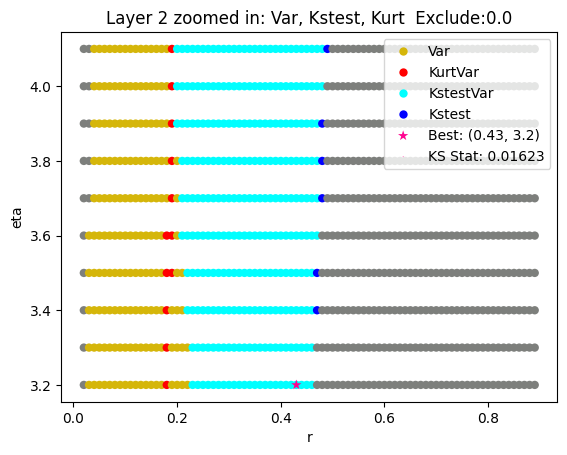

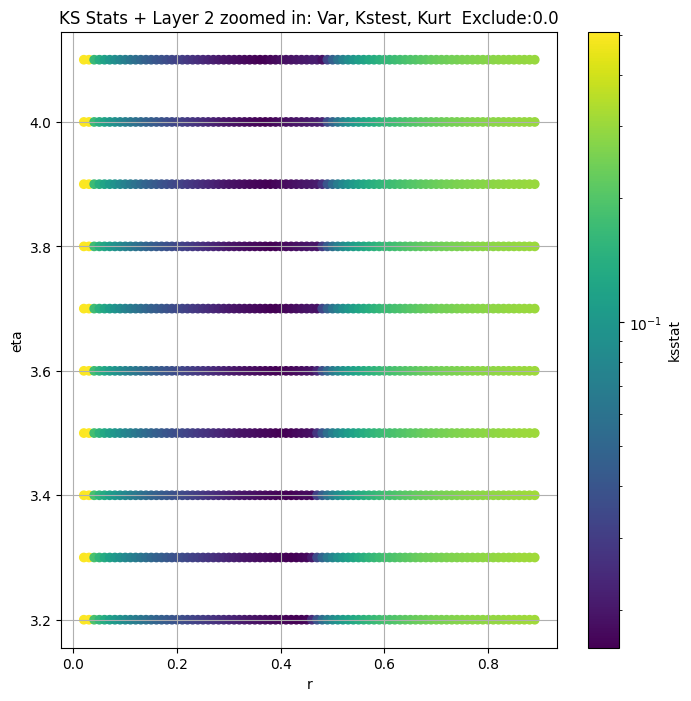

Layer 3


  0%|          | 0/880 [00:00<?, ?it/s]

Finding Minimum after computing 880 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.029629921780675347, var: 3379652.75


  0%|          | 0/880 [00:00<?, ?it/s]

Finding Minimum after computing 880 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.024780842986243126, var: 3593237.0


  0%|          | 0/880 [00:00<?, ?it/s]

Finding Minimum after computing 880 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.01902753245665327, var: 3844578.5


  0%|          | 0/880 [00:00<?, ?it/s]

Finding Minimum after computing 880 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.012925865565439246, var: 4166414.5


  0%|          | 0/880 [00:00<?, ?it/s]

Finding Minimum after computing 880 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.008634479973741851, var: 4688396.5
Number of samples: 6416, Without approximation : 6416


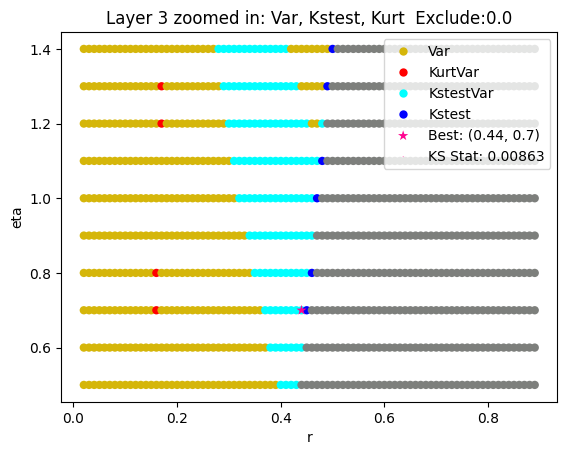

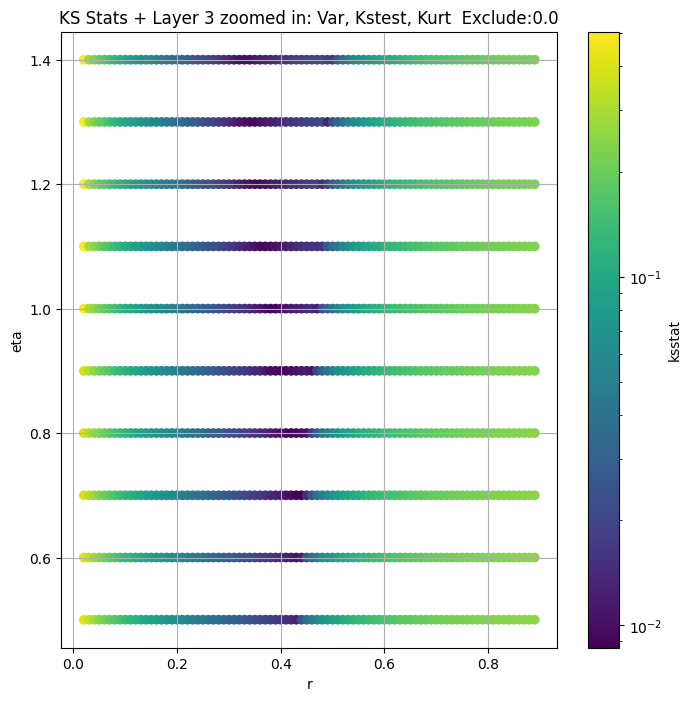

Layer 4


  0%|          | 0/1224 [00:00<?, ?it/s]

Finding Minimum after computing 1224 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.013985883701642332, var: 862581.6875


  0%|          | 0/1224 [00:00<?, ?it/s]

Finding Minimum after computing 1224 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.012764236771970638, var: 887952.5625


  0%|          | 0/1224 [00:00<?, ?it/s]

Finding Minimum after computing 1224 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.011451421405621054, var: 916742.125


  0%|          | 0/1224 [00:00<?, ?it/s]

Finding Minimum after computing 1224 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.010502993416968462, var: 950892.9375


  0%|          | 0/1224 [00:00<?, ?it/s]

Finding Minimum after computing 1224 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.008756941511181005, var: 998722.25
Number of samples: 25664, Without approximation : 25664


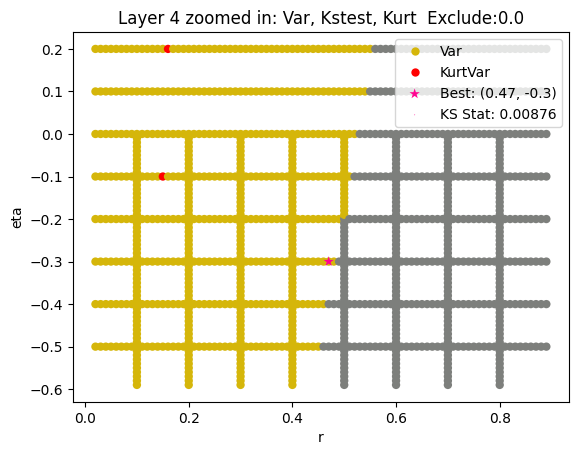

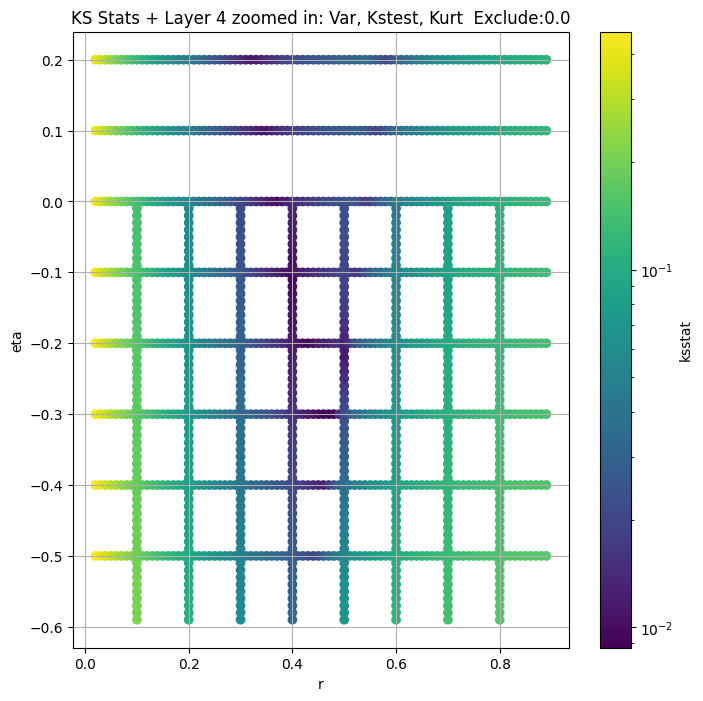

Layer 5


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 50.0 + 100 = 150, ksstat: 0.011122583639364914, var: 179580.3125


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 50.0 + 75 = 125, ksstat: 0.010935215325535652, var: 181727.78125


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 50.0 + 50 = 100, ksstat: 0.010559205333537491, var: 184034.125


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 50.0 + 25 = 75, ksstat: 0.009982929965495546, var: 186510.28125


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 50.0 + 0 = 50, ksstat: 0.009675120249043934, var: 189239.171875


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 50.0 + -25 = 25, ksstat: 0.009062070723462545, var: 192335.703125


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 50.0 + -50 = 0, ksstat: 0.008512261214642547, var: 196466.640625
Number of samples: 100000, Without approximation : 102656


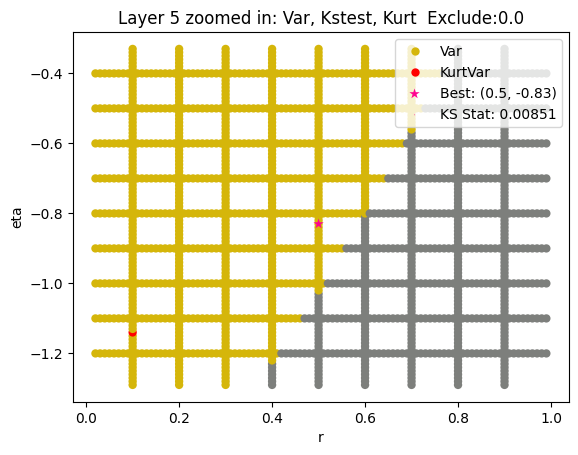

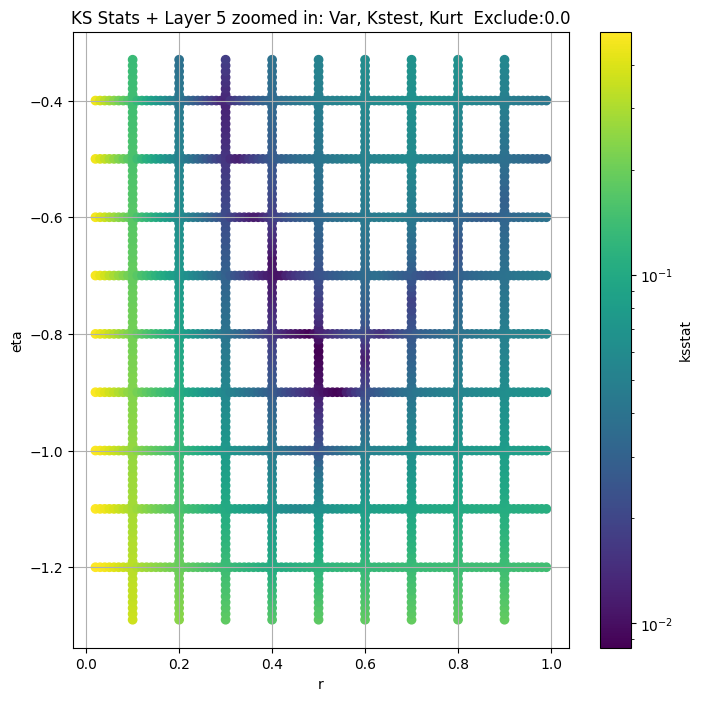

Layer 6


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 200.0 + 100 = 300, ksstat: 0.01170777946466954, var: 28800.21875


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 200.0 + 75 = 275, ksstat: 0.01155531477826379, var: 29167.220703125


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 200.0 + 50 = 250, ksstat: 0.010985335948324751, var: 29550.33984375


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 200.0 + 25 = 225, ksstat: 0.011065828731616545, var: 29950.033203125


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 200.0 + 0 = 200, ksstat: 0.01083269903168882, var: 30371.037109375


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 200.0 + -25 = 175, ksstat: 0.011241366383350049, var: 30819.15234375


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 200.0 + -50 = 150, ksstat: 0.010986360711816578, var: 31292.40234375


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 200.0 + -75 = 125, ksstat: 0.011217715488177196, var: 31796.904296875


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 200.0 + -100 = 100, ksstat: 0.010820285134158517, var: 32342.275390625
Number of samples: 100000, Without approximation : 410624


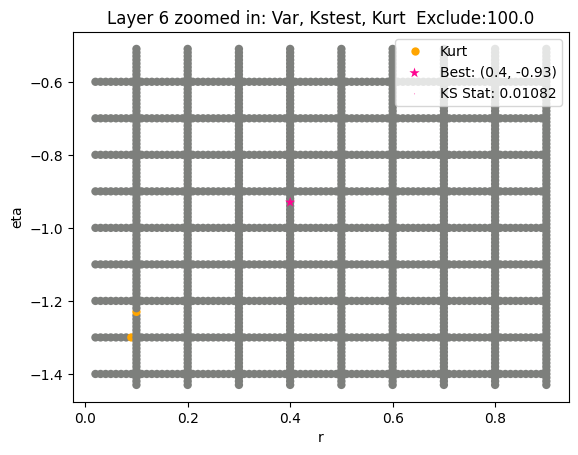

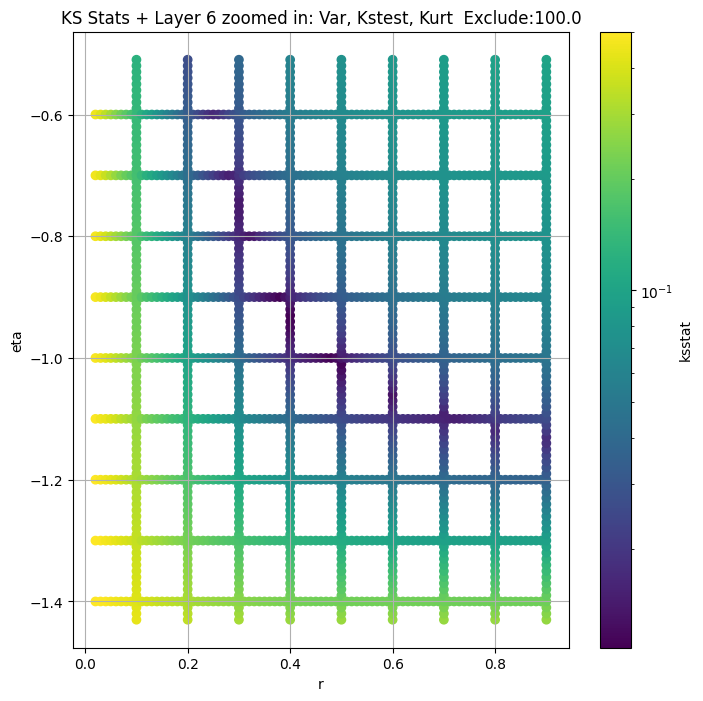

Layer 7


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 7, 250.0 + 100 = 350, ksstat: 0.018318352665679494, var: 4600.40380859375


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 7, 250.0 + 75 = 325, ksstat: 0.017745611900013003, var: 4671.74755859375


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 7, 250.0 + 50 = 300, ksstat: 0.01791501531548012, var: 4746.27099609375


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 7, 250.0 + 25 = 275, ksstat: 0.01810139430765989, var: 4824.28515625


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 7, 250.0 + 0 = 250, ksstat: 0.018292585088522995, var: 4906.06787109375


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 7, 250.0 + -25 = 225, ksstat: 0.01842370265398874, var: 4992.021484375


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 7, 250.0 + -50 = 200, ksstat: 0.017763965592615727, var: 5082.8974609375


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 7, 250.0 + -75 = 175, ksstat: 0.017882456707529137, var: 5179.60595703125


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 7, 250.0 + -100 = 150, ksstat: 0.01871813149981305, var: 5282.5751953125
Number of samples: 100000, Without approximation : 1642496


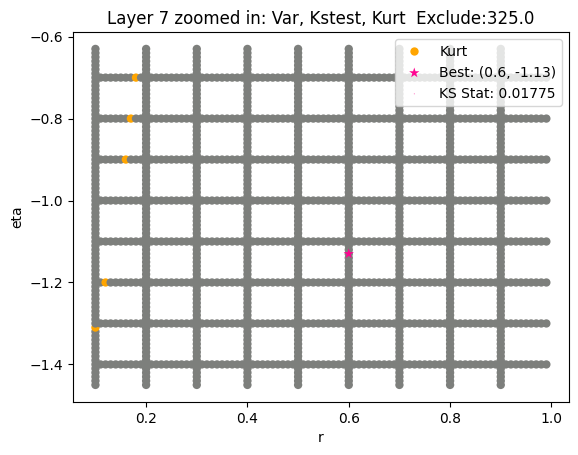

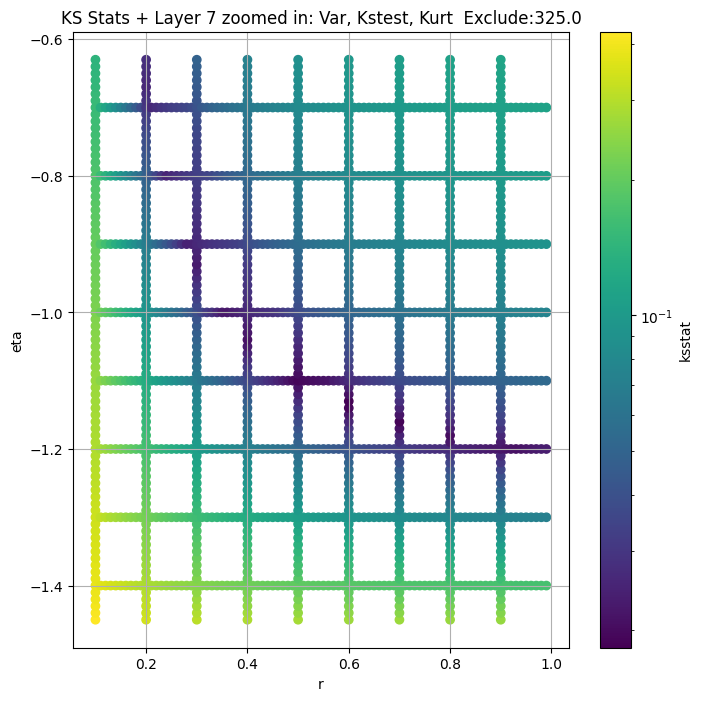

Layer 8


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 75.0 + 100 = 175, ksstat: 0.007233727064519441, var: 908.6233520507812


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 75.0 + 75 = 150, ksstat: 0.006574036538804347, var: 932.1405639648438


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 75.0 + 50 = 125, ksstat: 0.007098545751321787, var: 957.7576904296875


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 75.0 + 25 = 100, ksstat: 0.006490144917155771, var: 986.0474853515625


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 75.0 + 0 = 75, ksstat: 0.0065437262250295225, var: 1017.8264770507812


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 75.0 + -25 = 50, ksstat: 0.005501236605474455, var: 1054.4739990234375


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 75.0 + -50 = 25, ksstat: 0.005224983791768056, var: 1098.8489990234375


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 75.0 + -75 = 0, ksstat: 0.00520178634067181, var: 1162.6064453125
Number of samples: 100000, Without approximation : 6569984


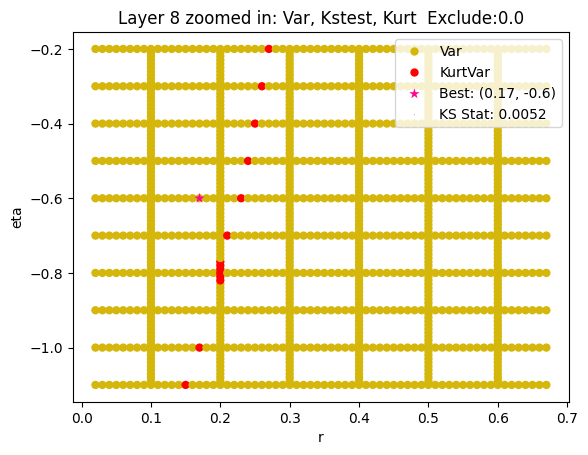

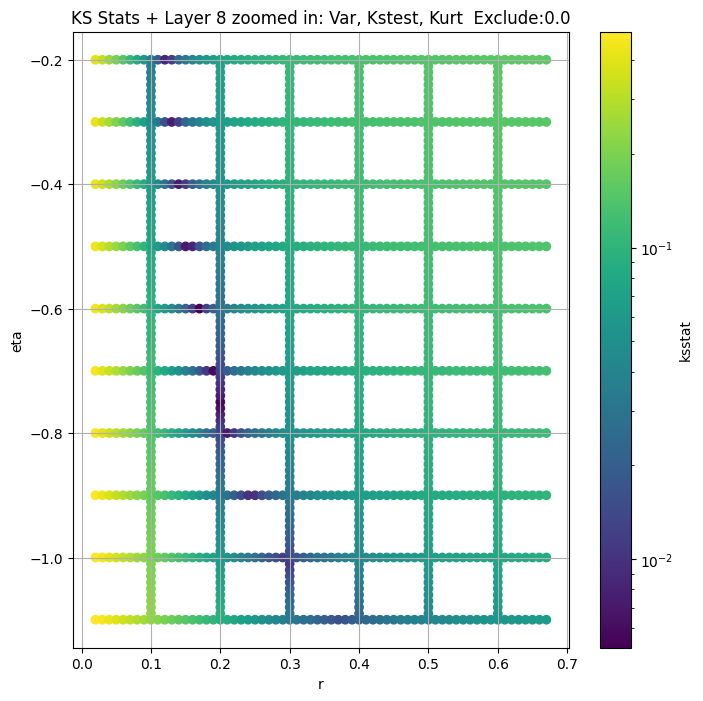

Layer 9


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
layer 9, 25.0 + 100 = 125, ksstat: 0.012543562825361482, var: 195.68043518066406


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
layer 9, 25.0 + 75 = 100, ksstat: 0.013030190131603447, var: 202.6957550048828


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
layer 9, 25.0 + 50 = 75, ksstat: 0.012791930055037093, var: 210.66287231445312


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
layer 9, 25.0 + 25 = 50, ksstat: 0.01321053484719309, var: 219.9466094970703


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
layer 9, 25.0 + 0 = 25, ksstat: 0.012164207904282298, var: 231.30809020996094


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
layer 9, 25.0 + -25 = 0, ksstat: 0.012091682201733955, var: 247.93588256835938
Number of samples: 100000, Without approximation : 26279936


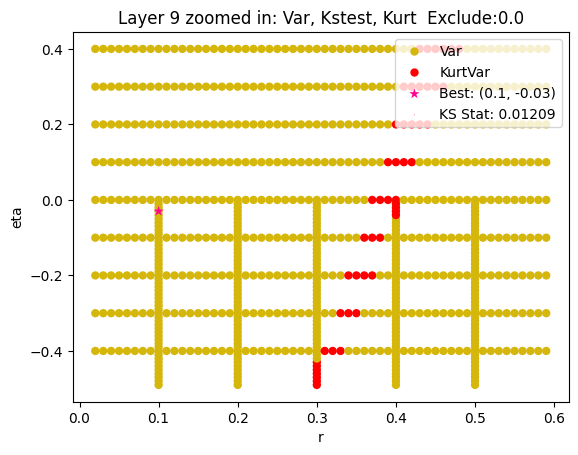

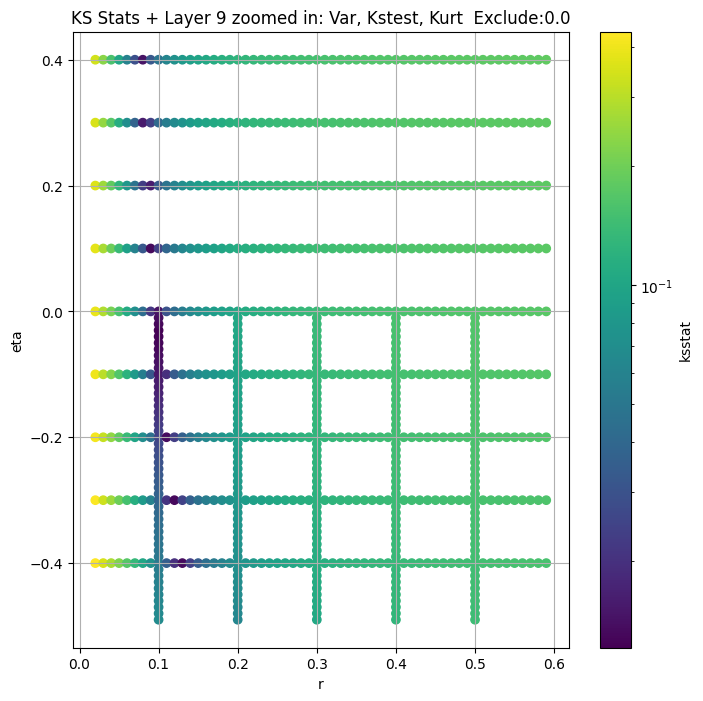

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      1.944126e+07  1.727396e+07  2.176802e+07   1.198365    0.473946   
3      4.688396e+06  4.386526e+06  4.998034e+06   2.127208    1.684596   
4      9.987222e+05  9.389650e+05  1.060140e+06   3.486293    2.938743   
5      1.964666e+05  1.828806e+05  2.107052e+05   5.660023    4.755314   
6      3.547586e+04  3.247593e+04  3.864024e+04   9.517805    7.861723   
7      6.216240e+03  5.591804e+03  6.895085e+03  14.437410   11.702306   
8      1.162606e+03  1.020683e+03  1.318852e+03  22.518257   17.539236   
9      2.479359e+02  2.136317e+02  2.857319e+02  30.058044   22.701000   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        2.049889           1604             0.016244        0.4          3.6   
3        2.595376           6416             0.009067        0.4          0.9   
4        4.103294          25664             0.009867        0.4         -0.1   
5        6.740086         102656             0.009675        0.5         -0.8   
6       11.440639         410624             0.010833        0.5         -1.0   
7       18.183810        1642496             0.019066        0.5         -1.1   
8       28.702457        6569984             0.006668        0.2         -0.7   
9       40.466720       26279936             0.012164        0.1          0.0   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       2.912026e+04                     0.0        1.944126e+07   
3       4.008773e+04                     0.0        4.688396e+06   
4       2.765920e+04                     0.0        9.987222e+05   
5       5.632118e+04                    50.0        1.964666e+05   
6       1.518552e+04                   200.0        3.234228e+04   
7       3.406992e+03                   250.0        4.671748e+03   
8       1.514623e-01                    75.0        1.162606e+03   
9       3.250076e-11                    25.0        2.479359e+02   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.033804          0.016229    0.43      3.20   
3                     0.016929          0.008634    0.44      0.70   
4                     0.008471          0.008757    0.47     -0.30   
5                     0.004237          0.008512    0.50     -0.83   
6                     0.002119          0.010820    0.40     -0.93   
7                     0.001060          0.017746    0.60     -1.13   
8                     0.000530          0.005202    0.17     -0.60   
9                     0.000265          0.012092    0.10     -0.03   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      6.534781e+04                  0.0         6849  
3      9.324745e+04                  0.0        24360  
4      9.186553e+04                  0.0        24360  
5      6.265679e+04                  0.0        25664  
6      5.244558e+03                100.0        16240  
7      5.872751e+03                325.0         6088  
8      7.969929e-03                  0.0        64962  
9      4.082447e-11                  0.0        12832

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

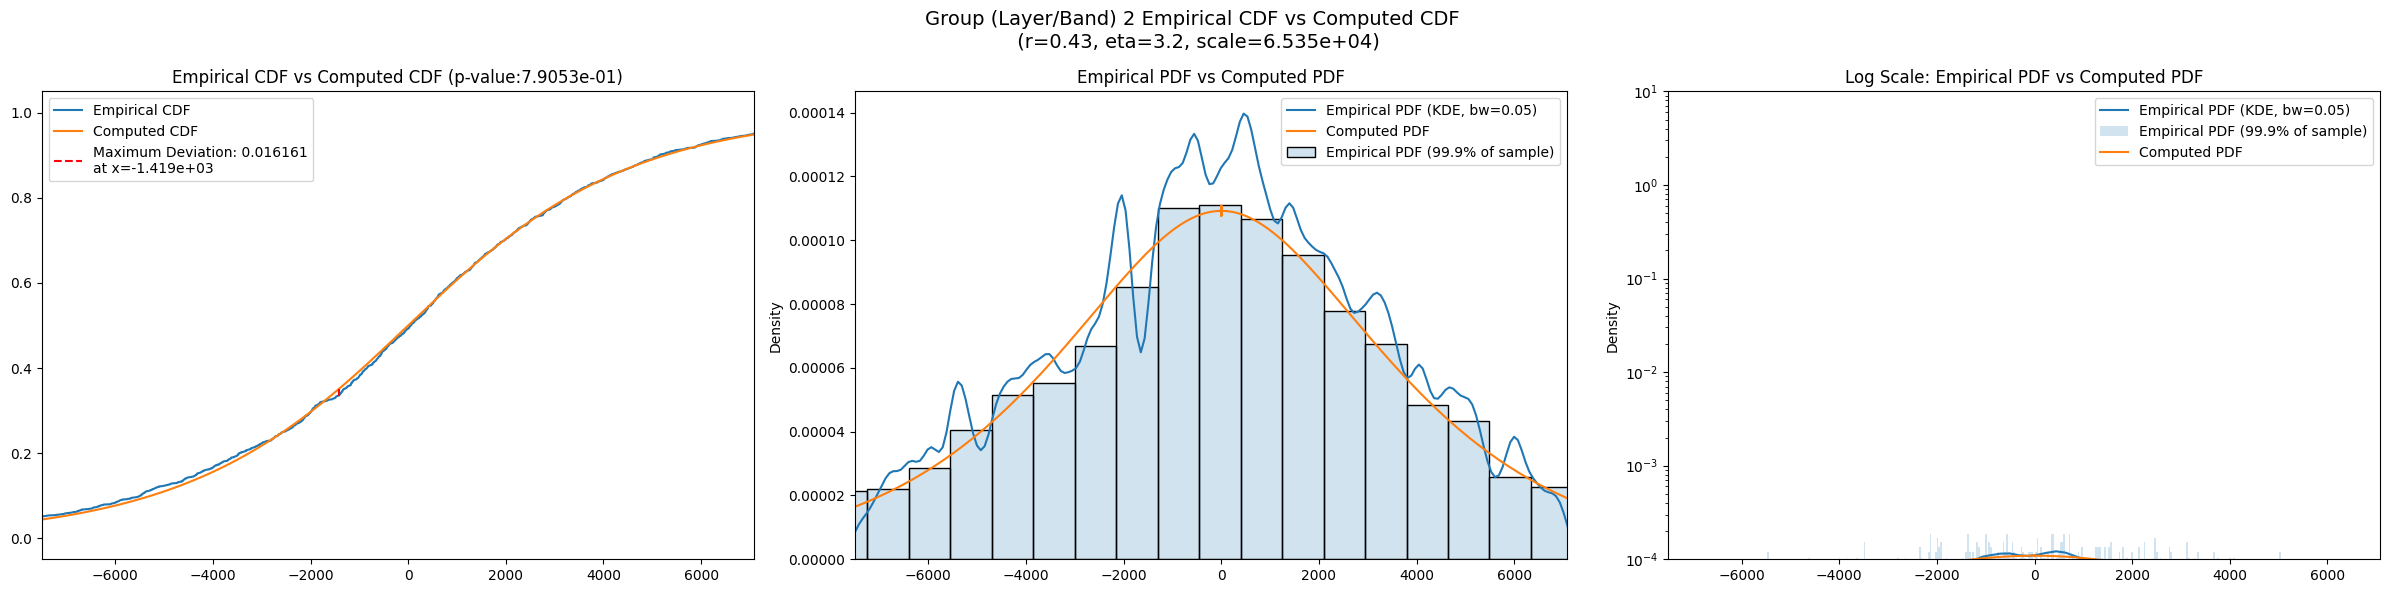

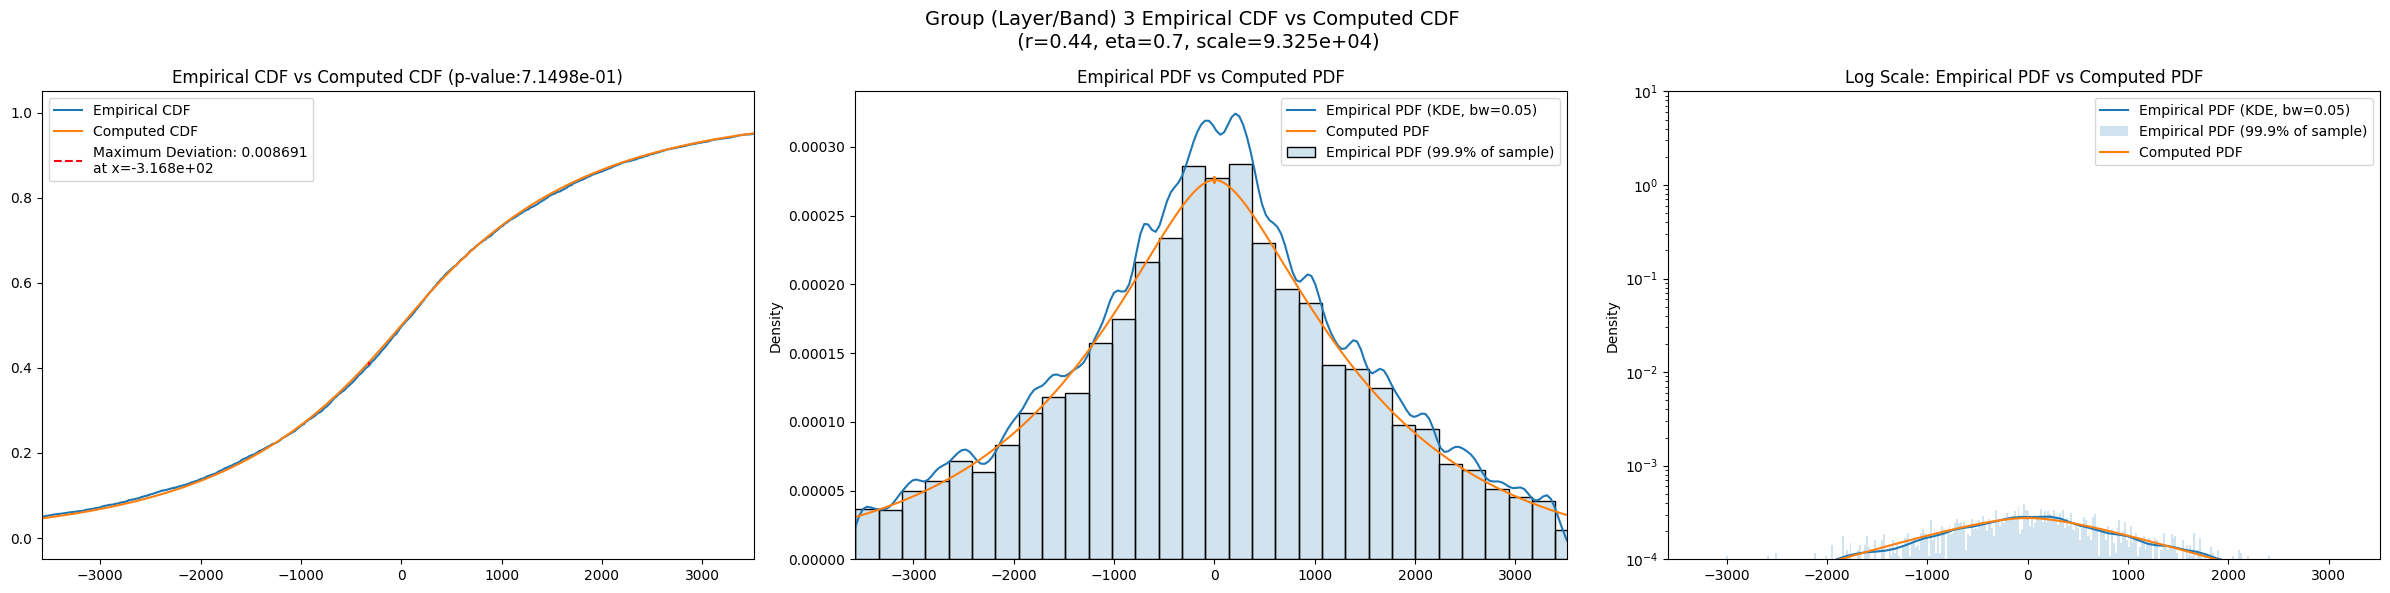

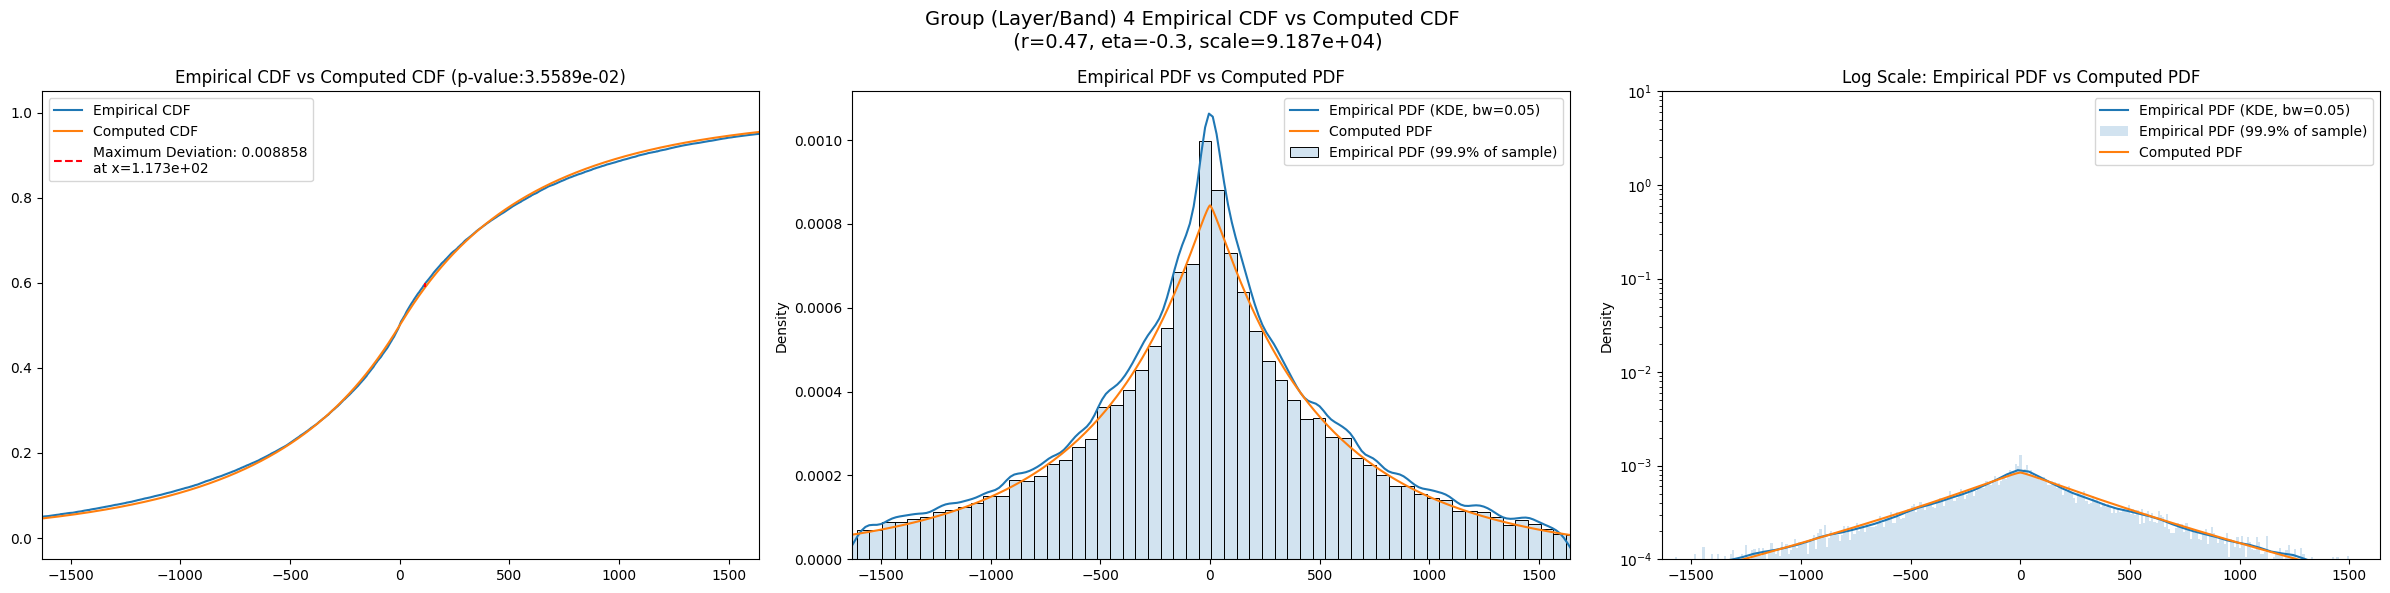

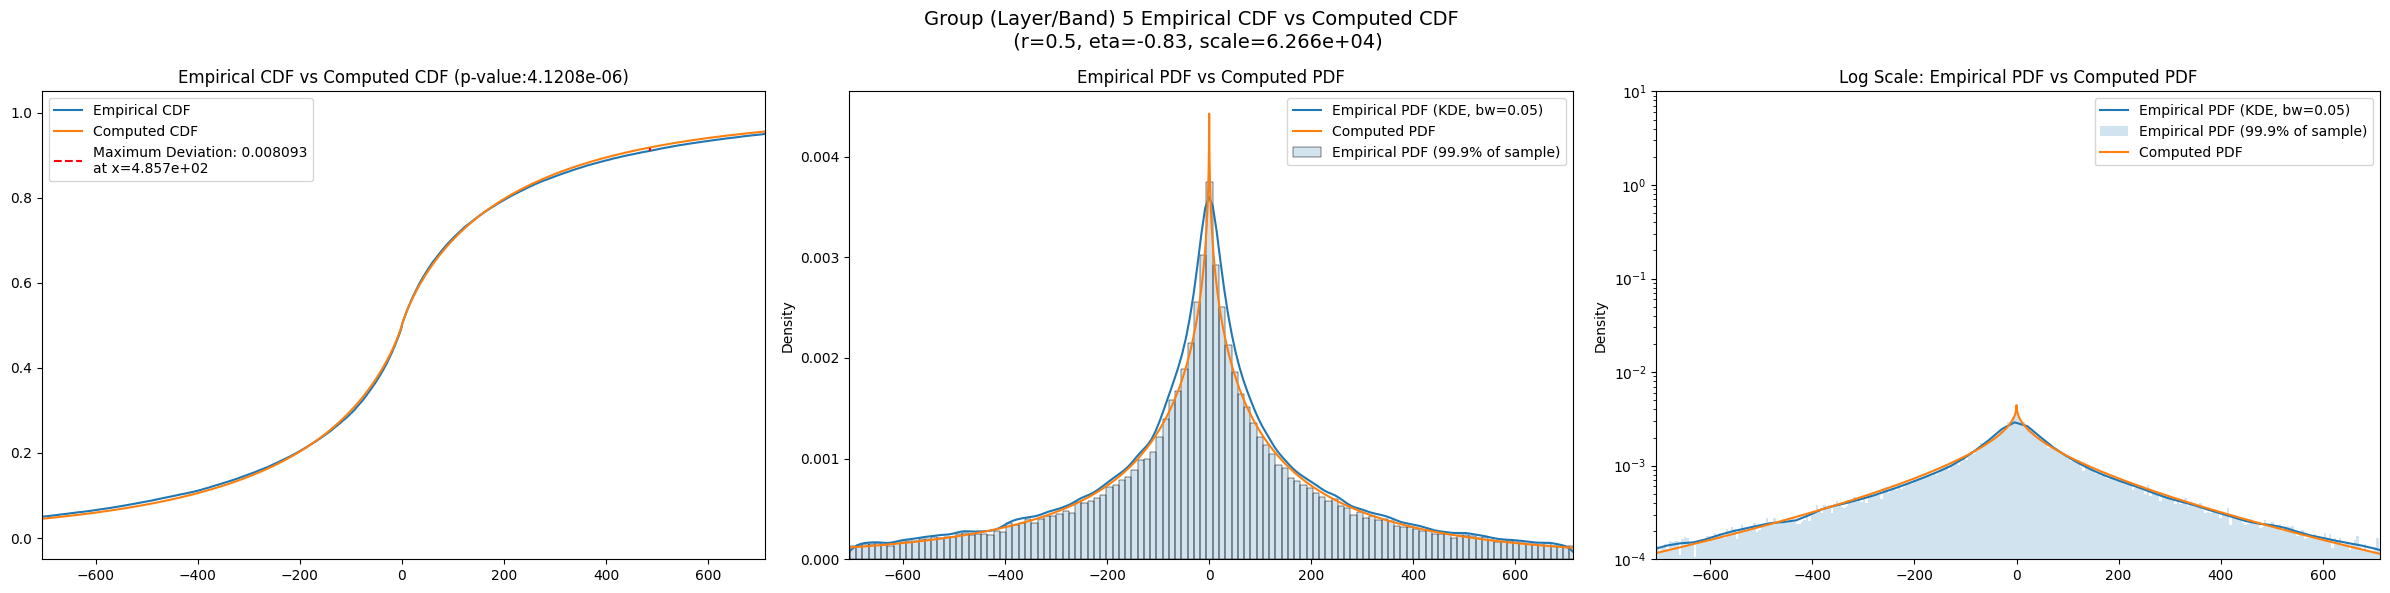

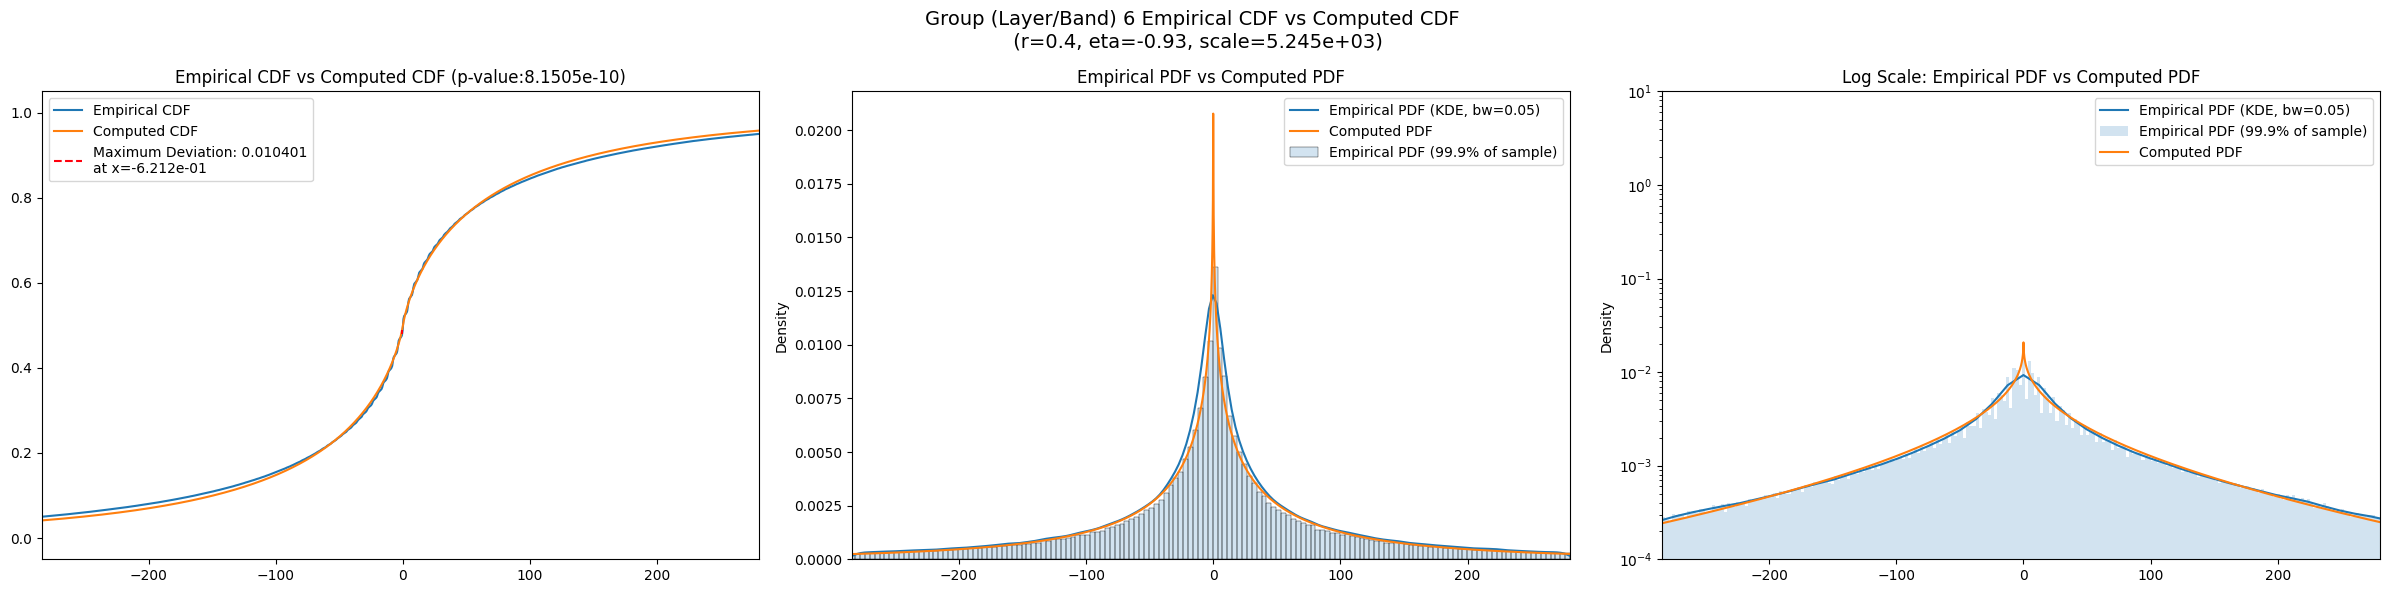

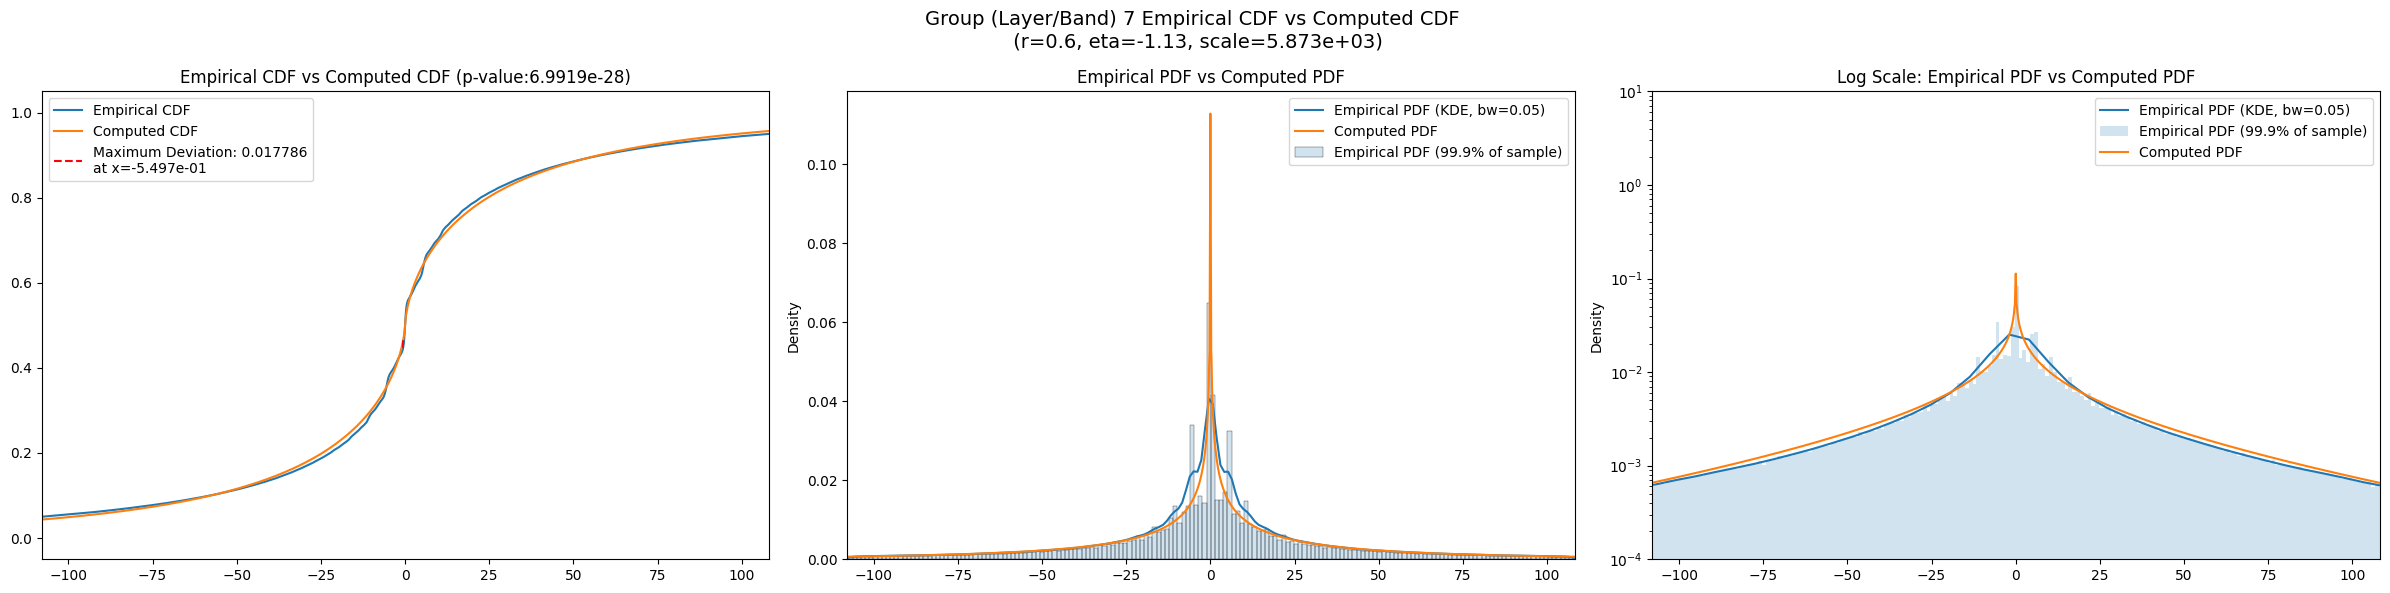

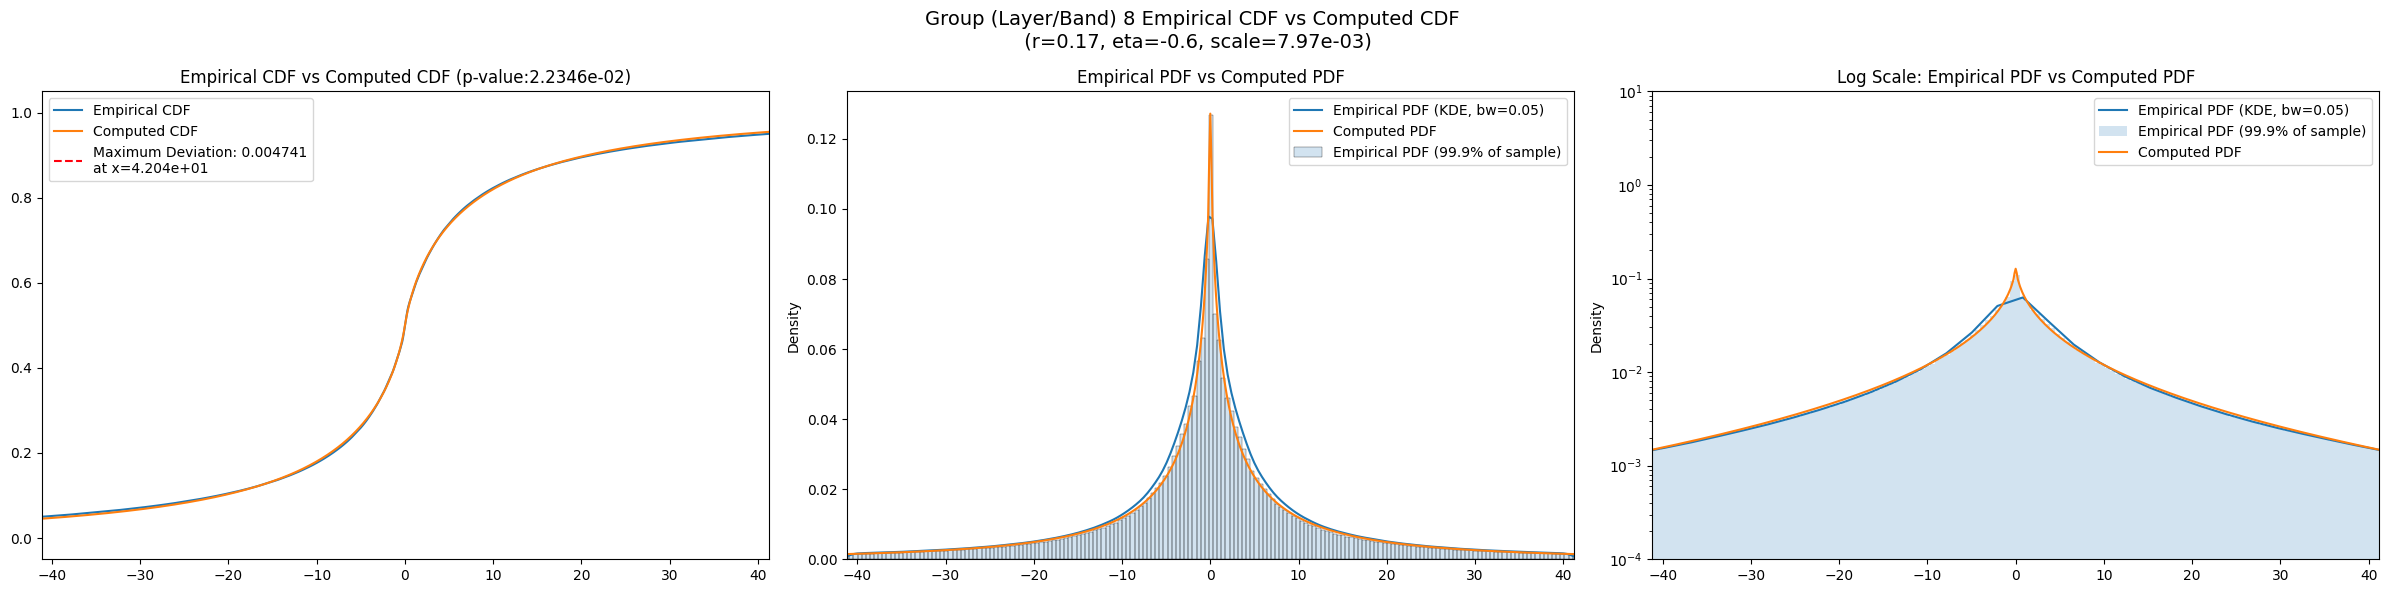

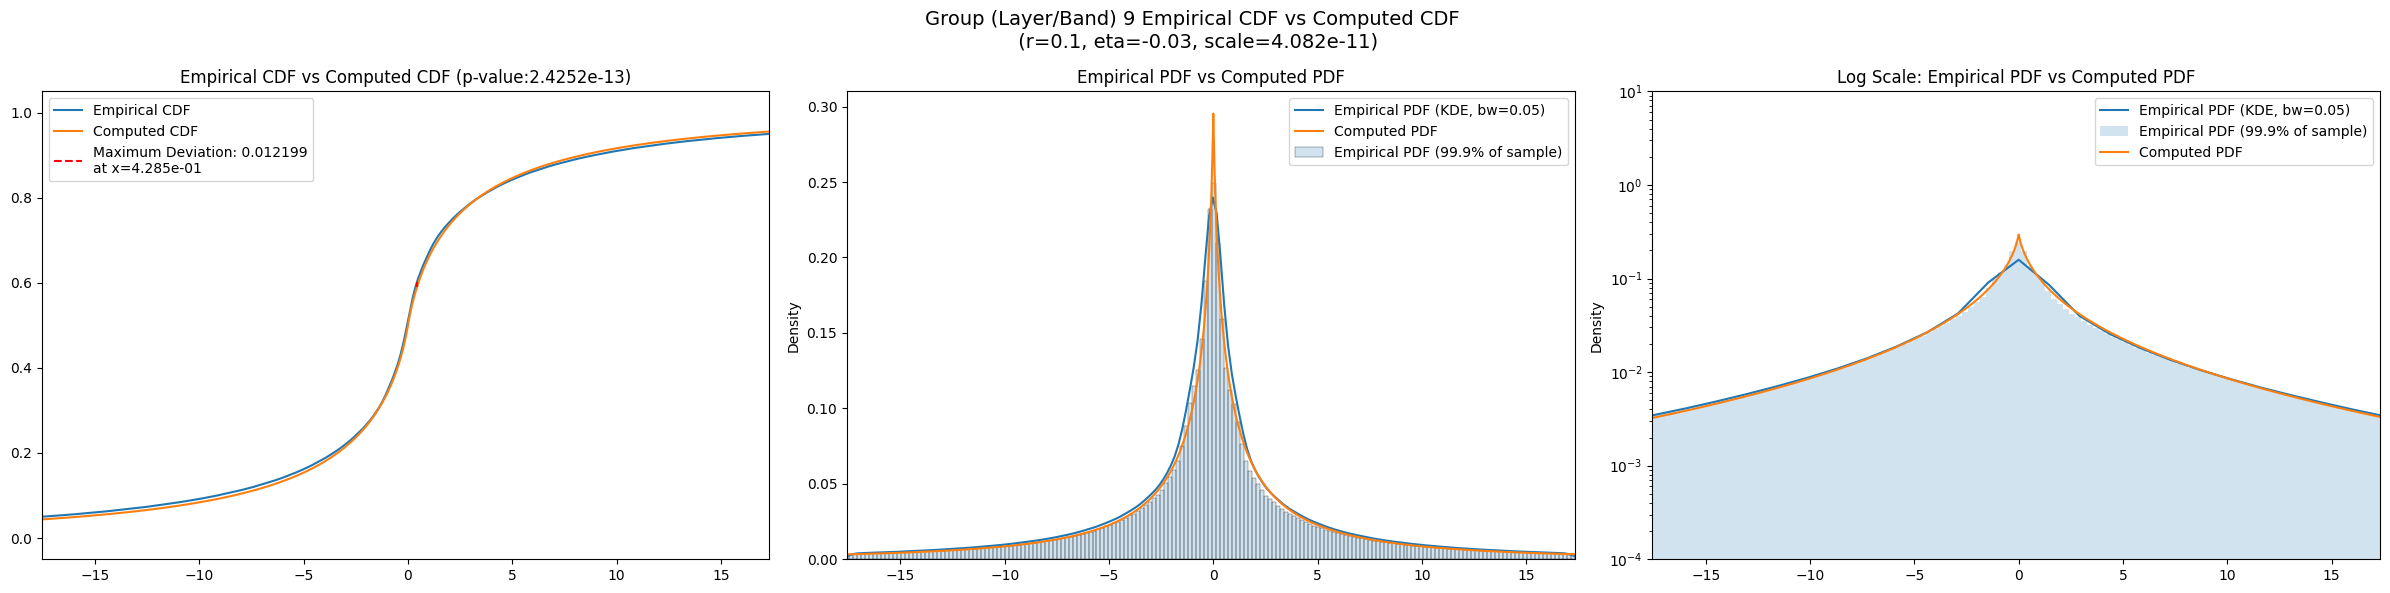

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      1.944126e+07  1.727396e+07  2.176802e+07   1.198365    0.473946   
3      4.688396e+06  4.386526e+06  4.998034e+06   2.127208    1.684596   
4      9.987222e+05  9.389650e+05  1.060140e+06   3.486293    2.938743   
5      1.964666e+05  1.828806e+05  2.107052e+05   5.660023    4.755314   
6      3.547586e+04  3.247593e+04  3.864024e+04   9.517805    7.861723   
7      6.216240e+03  5.591804e+03  6.895085e+03  14.437410   11.702306   
8      1.162606e+03  1.020683e+03  1.318852e+03  22.518257   17.539236   
9      2.479359e+02  2.136317e+02  2.857319e+02  30.058044   22.701000   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        2.049889           1604             0.016244        0.4          3.6   
3        2.595376           6416             0.009067        0.4          0.9   
4        4.103294          25664             0.009867        0.4         -0.1   
5        6.740086         102656             0.009675        0.5         -0.8   
6       11.440639         410624             0.010833        0.5         -1.0   
7       18.183810        1642496             0.019066        0.5         -1.1   
8       28.702457        6569984             0.006668        0.2         -0.7   
9       40.466720       26279936             0.012164        0.1          0.0   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...      3941.41000              0.024594          2.818300e-01   
3      ...      1782.22000              0.029967          1.936750e-05   
4      ...       724.11400              0.041856          1.662180e-39   
5      ...       259.48700              0.060110          0.000000e+00   
6      ...        85.60240              0.073174          0.000000e+00   
7      ...        28.47620              0.080209          0.000000e+00   
8      ...        11.12780              0.073930          0.000000e+00   
9      ...         4.37703              0.081972          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace     param_t  \
layer                                                                        
2         3546.35000             0.019995         5.361230e-01  2880.68000   
3         1604.36000             0.008579         7.290270e-01  1296.36000   
4          629.36800             0.014745         2.817120e-05   514.62800   
5          225.51900             0.032645         1.767260e-95   179.60200   
6           73.70930             0.047603         0.000000e+00    57.77070   
7           24.66630             0.054762         0.000000e+00    19.22530   
8            9.82869             0.048255         0.000000e+00     7.54982   
9            3.83098             0.055840         0.000000e+00     2.97103   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.024078   3.053430e-01          7.857048e-01  
3           0.013399   1.977580e-01          7.217144e-01  
4           0.019706   4.345320e-09          3.882198e-02  
5           0.035177  8.425580e-111          6.880851e-07  
6           0.048794   0.000000e+00          3.460856e-42  
7           0.054545   0.000000e+00          0.000000e+00  
8           0.046732   0.000000e+00         7.701988e-155  
9           0.055600   0.000000e+00          0.000000e+00  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.016244                 0.033804          0.016229   
3                 0.009067                 0.016929          0.008634   
4                 0.009867                 0.008471          0.008757   
5                 0.009675                 0.004237          0.008512   
6                 0.010833                 0.002119          0.010820   
7                 0.019066                 0.001060          0.017746   
8                 0.006668                 0.000530          0.005202   
9                 0.012164                 0.000265          0.012092   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.024594             0.019995       0.024078  
3                  0.029967             0.008579       0.013399  
4                  0.041856             0.014745       0.019706  
5                  0.060110             0.032645       0.035177  
6                  0.073174             0.047603       0.048794  
7                  0.080209             0.054762       0.054545  
8                  0.073930             0.048255       0.046732  
9                  0.081972             0.055840       0.055600

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2            1.944126e+07          0.016229    0.43      3.20  6.534781e+04   
3            4.688396e+06          0.008634    0.44      0.70  9.324745e+04   
4            9.987222e+05          0.008757    0.47     -0.30  9.186553e+04   
5            1.964666e+05          0.008512    0.50     -0.83  6.265679e+04   
6            3.234228e+04          0.010820    0.40     -0.93  5.244558e+03   
7            4.671748e+03          0.017746    0.60     -1.13  5.872751e+03   
8            1.162606e+03          0.005202    0.17     -0.60  7.969929e-03   
9            2.479359e+02          0.012092    0.10     -0.03  4.082447e-11   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                      0.0  
5                      0.0  
6                    100.0  
7                    325.0  
8                      0.0  
9                      0.0

In [21]:
eng.quit()